In [1]:
# by Joh Schöneberg 2018

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from numpy import genfromtxt


import pandas as pd

from mpl_toolkits import mplot3d
#%matplotlib notebook

import math

#import cv2
import pims
from PIL import Image

import skimage

import json


import pylattice
import pylattice.functions.InputProcessing as inproc
import pylattice.functions.TiffProcessing as tiffproc
import pylattice.classes.Track as Track

# input data

In [2]:
path = '/Users/johannesschoeneberg/Dropbox/pylattice_testData/imaging_data/'


filepath = path+'_inputParameters.csv'
print(filepath)
inputParameters = pd.read_csv(filepath,names=['key','value'])


inputDataFolder = inproc.getInputParameter(inputParameters,"inputDataFolder")
outputDataFolder = inproc.getInputParameter(inputParameters,"outputDataFolder")
trackingCsvFilenameProcessed = inproc.getInputParameter(inputParameters,"trackingCsvFilenameProcessed")


slave_outputDataFolder  = inproc.getInputParameter(inputParameters,"slave_outputDataFolder")
master_outputDataFolder  = inproc.getInputParameter(inputParameters,"master_outputDataFolder")

slave_uniqueFilenameString = inproc.getInputParameter(inputParameters,"slave_uniqueFilenameString")
master_uniqueFilenameString = inproc.getInputParameter(inputParameters,"master_uniqueFilenameString")


slave_trackingProcessedBildFilename = inproc.getInputParameter(inputParameters,"slave_trackingProcessedBildFilename")
master_trackingProcessedBildFilename = inproc.getInputParameter(inputParameters,"master_trackingProcessedBildFilename")



framerate_msec = float(inproc.getInputParameter(inputParameters,"framerate_msec"))
movieLength = int(inproc.getInputParameter(inputParameters,"movieLength"))

/Users/johannesschoeneberg/Dropbox/pylattice_testData/imaging_data/_inputParameters.csv


In [5]:
# read the raw csv data for further processing

filepath = path+outputDataFolder+'/'+trackingCsvFilenameProcessed
print(filepath)


data = pd.read_csv(filepath,header=0)
data.columns = ["trackId","tracklength","time[s]","frameId","lifetime","catIdx","m_x",'m_y',"m_z","m_A","m_c","m_pval_Ar","s_x",'s_y',"s_z","s_A","s_c","s_pval_Ar"]
trackIds = data.drop_duplicates(subset='trackId')['trackId'].values

data[0:5]

/Users/johannesschoeneberg/Dropbox/pylattice_testData/imaging_data/./output/trackedFeaturesProcessed.csv


,trackId,tracklength,time[s],frameId,lifetime,catIdx,m_x,m_y,m_z,m_A,m_c,m_pval_Ar,s_x,s_y,s_z,s_A,s_c,s_pval_Ar
0,1,10,0,1,56.89,4,8.392389e+01,7.829316e+01,9.203630e+01,1.621301e+04,5.337351e+03,0,8.326611e+01,7.794542e+01,9.203630e+01,5.091087e+04,1.545746e+04,0
1,1,10,5.689000e+00,2,56.89,4,8.308114e+01,7.839055e+01,9.139372e+01,1.641240e+04,5.377369e+03,0,8.225718e+01,7.789788e+01,9.139372e+01,4.208727e+04,1.703191e+04,1.707952e-309
2,1,10,1.137800e+01,3,56.89,4,8.234555e+01,7.849892e+01,9.294057e+01,1.648831e+04,5.028025e+03,0,8.168735e+01,7.793985e+01,9.294057e+01,2.405039e+04,1.658124e+04,1.410429e-146
3,1,10,1.706700e+01,4,56.89,4,8.245539e+01,7.872510e+01,9.181465e+01,2.237740e+04,6.284561e+03,0,8.211642e+01,7.789129e+01,9.181465e+01,3.467488e+04,1.837804e+04,7.833881e-265
4,1,10,2.275600e+01,5,56.89,4,8.300636e+01,7.756059e+01,9.108647e+01,1.872806e+04,5.872613e+03,0,8.224775e+01,7.669614e+01,9.108647e+01,3.536519e+04,1.660408e+04,0


# gather statistics

[14, 0, 156, 31, 0, 0, 3, 1]


Text(0.5,1,'N = 205')

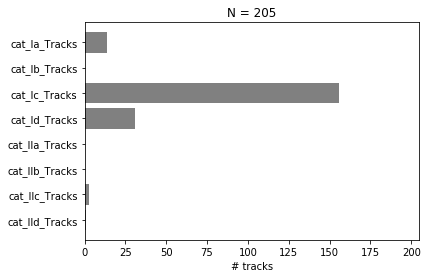

In [9]:
#plot them all

#%----------------------------------------------------------------------------
#    % I. Assign category to each track
#    %----------------------------------------------------------------------------
#    % Categories:
#    % Ia)  Single tracks with valid gaps
#    % Ib)  Single tracks with invalid gaps
#    % Ic)  Single tracks cut at beginning or end
#    % Id)  Single tracks, persistent
#    % IIa) Compound tracks with valid gaps
#    % IIb) Compound tracks with invalid gaps
#    % IIc) Compound tracks cut at beginning or end
#    % IId) Compound tracks, persistent
#    
#    % The categories correspond to index 1-8, in the above order



#data = longtracks
data = data

allTracks = np.unique(data['trackId'].values)
cat_Ia_Tracks = np.unique(data[data['catIdx'] == 1]['trackId'])
cat_Ib_Tracks = np.unique(data[data['catIdx'] == 2]['trackId'])
cat_Ic_Tracks = np.unique(data[data['catIdx'] == 3]['trackId'])
cat_Id_Tracks = np.unique(data[data['catIdx'] == 4]['trackId'])
cat_IIa_Tracks = np.unique(data[data['catIdx'] == 5]['trackId'])
cat_IIb_Tracks = np.unique(data[data['catIdx'] == 6]['trackId'])
cat_IIc_Tracks = np.unique(data[data['catIdx'] == 7]['trackId'])
cat_IId_Tracks = np.unique(data[data['catIdx'] == 8]['trackId'])

categories = [cat_Ia_Tracks,cat_Ib_Tracks,cat_Ic_Tracks,cat_Id_Tracks,cat_IIa_Tracks,cat_IIb_Tracks,cat_IIc_Tracks,cat_IId_Tracks]
categoryLabels = ["cat_Ia_Tracks","cat_Ib_Tracks","cat_Ic_Tracks","cat_Id_Tracks","cat_IIa_Tracks","cat_IIb_Tracks","cat_IIc_Tracks","cat_IId_Tracks"]

categoryFrequency = []
for cat in categories:
    categoryFrequency.append(len(cat))
    
print(categoryFrequency)



# https://matplotlib.org/gallery/lines_bars_and_markers/barh.html
fig, ax = plt.subplots()



ax.barh(y_pos, categoryFrequency, xerr=error, align='center',
        color='grey', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(categoryLabels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('# tracks')
ax.set_xlim(0,len(allTracks))
ax.set_title('N = '+str(len(allTracks)))